<a href="https://colab.research.google.com/github/ctkakau/AIML425_A3/blob/main/AIML425_A3_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIML425 Assignment 3 - Convolutional Neural Networks  

## 1D convolution

- Use a linear discrete 1D convolution to create a database with at least 1000 entries.  Each entry contains one of five "sounds".  For each entry, linearly convolve a new instance of 2000 iid Gaussian samples with one of five different filters (impulse responses, kernels).  if you play the files over a loudspeaker (8kHz sampling) they should sound different.  

  [One method:  take a Hamming window shape (readily available) of suitable length (short is good) as  first kernel (filter).  Then multiply that kernel by $sin(\omega t)$, where $t \in \mathbb{Z}$ is time, with different frequencies $\omega \in [0, \pi]$ to create four more filters, each passing through a different frequency band.]

- Design a simple 1D convolutional network using convolution, pooling and other tools with a one-hot output that classifies the sounds in the file.

- Test and optimize your setup with suitable methods.  

- Extend this toy study in one direction of your choice to provide additional insight in the behaviour of 1D convolution (for example, what happens with mixed signals, different file lengths, distorted filters, batch normalization, etc).  Provide a solid motivation and reasoning.




## Generating audio signals, adding noise and using Convolutional Neural Networks to train and classify

This project generates five (5) audio signals (2 second tones at different frequencies) and uses these audio signals to train a convolutional neural network.  We will follow this general process:

  - Importing libraries  
  - generating audio signal (as a mixture of Hamming windows and sine waves at different angular frequencies)  
  - visualising generated signals for reference
  - save audio signals to file (to listen and share)
  - retrieving audio signal from file  
  - add Gaussian Noise to the signals to generate unique samples
  - design convolutional neural network 
  - train CNN on training data (with validation set)
  - test and evaluate CNN on test data  
  - adjust hyper-parameters to improve model performance  
  - recompile, train and test on the final model  
  - compare performance of initial and final models

The key concepts for this project are:  

- Fast Fourier Transform as a method to decompose a mixed frequency into it's component frequencies
- The use of 1D Convolutional Neural Networks to learn the importance of underlying features in predicting the class (main frequency) of an audio signal  
- The effect of combining two input signals (before adding noise) 

In order to conveniently build the convolutional neural network and take advantage of built-in machine learning models and functions we will use a range of functions and libraries from TensorFlow.  We will also be calling on a range of numpy math and array functions, writing an array to a soundfile (wav) and plotting using matplotlib.pyplot.

We begin by calling libraries:

In [1]:
# import libraries
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
!pip install tensorflow-io
import tensorflow_io as tfio

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split  

import numpy as np
from numpy.fft import fft, fftshift

!pip install sounddevice
!pip install soundfile
!sudo apt-get install libportaudio2 # required for sounddevice
import sounddevice as sd
import soundfile as sf

import math
import random
import time
import sys
# from google.colab import drive
# drive.mount('content/gdrive')



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.0 MB 1.5 MB/s 
     |████████████████████████████████| 2.4 MB 31.9 MB/s 
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.26.0
    Uninstalling tensorflow-io-gcs-filesystem-0.26.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.26.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  libportaudio2
0 upgraded, 1 newly installed, 0 to remove and

## generate the baseline sounds using Hamming window shapes

Numpy provides a range of functions for building an array that can be converted to an audio output.  To ensure a consistent file-size, numpy provides 'window' functions - waveforms that are a tapered signal, reducing the signal at each end, allowing for improved resolution of a target frequency (Harris, 1987). 

To generate our five fundamental frequencies we begin with a Hamming window, with length of 2 seconds and use this as the basis to combine with a sinusoidal wave across five other frequency bands.  We multiply our Hamming wndow by $sin(\omega t)$, where $\omega = 2 \pi f$, where $f$ is the input frequency.  $\omega$ and is also known as the _angular frequency_.  

According to Human Auditory and Visual Systems:
https://www.princeton.edu/~cuff/ele201/kulkarni_text/human.pdf 

Human detectable frequencies are between 15Hz to 20,000Hz, with upper limits deteriorating with age.  Frequency discrimination is around 0.3% of the target frequency, so we will separate our initial frequencies by at least this amount.  Setting our sampling rate to 8000 samples per second and frequency bands that provide clearly different audio tones, while keeping our visual plot manageable, we take the following frequencies:

$f \in {317Hz, 780, 1234Hz, 2017Hz, 3106Hz}$

To provide five angular frequencies:

$\omega t = 2*\pi*317*2$  
$\omega t = 2*\pi*780*2$  
$\omega t = 2*\pi*1234*2$  
$\omega t = 2*\pi*2017*2$  
$\omega t = 2*\pi*3106*2$  

These parameters will generate five individual, two-second samples, with a total of 16,000 elements, in a single channel.

We begin by defining some functions:
  - $\tt convert\_to\_audio()$ - takes an input array (float) and converts to integer for rendition as audio file
  - $\tt make\_waves()$ - takes array(s) of integers as input 'frequencies', and for each frequency (or mixture of frequencies if two array's given), mixes with a selected numpy.window method to output audio (.wav) files.  The function also produces visualisation (sinusoidal wave and FFT) for each frequency (or mixture) in the plot and as .png file.  Returns a tensor consisting of tensors for each frequency.
  - $\tt grab\_waves()$ - takes audio (.wav) files and converts to tensors for use in tensorflow.  Returns an array of tensors (each with shape [steps, channels]).
  - $\tt fill\_a\_bag()$ - takes the audio tensors and generates a random sample (of size sample_size) from those tensors.  Returns a tensor of shape (sample_size [steps, channels]).
  - $\tt main()$ - passes inputs to respective function to produce the randomly generated sample from given frequencies and output files for sharing or 

In [2]:
# function to convert float to integer for output as audio
def convert_to_audio(signal):
  x = (signal * 32768).astype(np.int16)
  return x


# function to calculate generate sin waves
# needs input details: f1 (freqs), f2 (freqs 2 for mix) - array of integers
# tim = seconds (integer, length of window)
def make_waves(f1, f2 = None, tim = 2, fs = 8000, window = 'hamming'):
  """generates an audio window"""
  
  import numpy as np
  import matplotlib.pyplot as plt
  import tensorflow as tf

  # determine number of timesteps
  t = np.arange(0, tim, step = 1/fs)
  m = t.size

  # call selected window method
  if window == "bartlett":
    window = np.bartlett(m)
  elif window == "blackman":
    window = np.blackman(m)
  elif window == "hamming":
    window = np.hamming(m)
  elif window == "hanning":
    window = np.hanning(m)
  
  out = []
  l = len (f1)
  
  # create a plot
  fig = plt.figure(figsize = (12, 6))
  fig.suptitle("Comparative sine waves (top) and fast fourier transforms (bottom)")
  # fig.supxlabel("frequency (Hz)")
  sub = fig.subplots(2, l)

  for i, f in enumerate(f1):

    # single frequency sine waves 
    if f2 == None:
      s = np.sin(2 * np.pi * f * t)
      #create a name for the wave file
      filename = format(str(f)+'.wav', )
    else:
      s = np.sin(2 * np.pi * f * t) + np.sin(2 * np.pi * f2[i] * t)
      #create a name for the wave file
      filename = ("{}_{}.wav".format(f, f2[i]) )
      f = ("{}_{}".format(f, f2[i]))
    
    # create window of approptiate size
    s_w = s * window

    # convert to tensor
    s_tf = tf.constant(s_w)
    # save tensor to output for use as transformed frequency
    out.append(s_tf)

    # generate fast fourier for display
    n = 8192
    w = np.fft.rfft(s_w, n = n)
    fq = np.fft.rfftfreq(n, d = t[1] - t[0])

    # convert to integers
    x = convert_to_audio(s_w)

    # write the wav to file 
    sf.write(filename, x, fs)


    ###########################
    # fill the plot
    ax1 = sub[0, i] # for sine wave
    ax2 = sub[1, i] # for FFT
    
    # # plot the sinusoids by time
    ax1.plot(t, s, label = "{} Hz".format(f))
    ax1.set_title("{} Hz".format(f))
    ax1.set_xlim(0.95, 0.96)
    ax1.set_xticklabels("")
    # ax1.set_xlabel("time")

    # plot the mixture of FFT and sin wave
    ax2.plot(fq, 20 *np.log10(np.abs(w)), label = f)
    ax2.set_title("FFT {} Hz".format(f))

  # saving plot to file    
  plt.savefig("sine_fft_main.png", )
  # print plot to output
  plt.show()
  out = tf.convert_to_tensor(out)

  return (out)

In [3]:
def grab_waves(f1, f2 = None, path = None):
  """function to grab audio .wav files and convert to tensor"""
  out = []

    

  for i, f in enumerate(f1):
    # change the file name for two 
    if f2 != None:
      f = ("{}_{}".format(f,f2[i]))
      
    if path != None:
      f_name = ("{}/{}.wav".format(f))
    else:
      # create filepath
      f_name = ("{}.wav".format(f))
    # retrieve file from path
    raw_audio = tf.io.read_file(f_name, )
    # convert file to Decode Tensor
    waveform = tf.audio.decode_wav(raw_audio)
    
    out.append(waveform)
  # out = tf.convert_to_tensor(out)

  return out

In [4]:
def fill_a_bag(bag, sample_size = 1000):
  """Function to generate a random sample drawn from a known bag"""
  
  # index the choices in the bag
  choices = np.arange(0, len(bag), step = 1)
  # select a bag full or random choices
  labels = random.choices(choices, k = sample_size)

  # holding array 
  out = []
  
  # iterate through the labels and retrieve the corresponding tensor
  for i, b in enumerate(labels):
    d = bag[b][0]
    out.append(d)

  # convert ouptut to tensor
  out = tf.convert_to_tensor(out)
  print("output tensor shape:", out.shape)

  return out, labels

In [5]:
def main(f1, f2=None, tim = 1, fs= 41000, sample_size = 1000, path = None):
  """Function to pull together all the other functions"""
  # create some wave forms, audio (.wav) and plots (.png)
  start = make_waves(f1 = f1, f2 = f2, tim = tim, fs = fs)

  # retrieve the generated audio files as tensors
  sounds = grab_waves(f1 = f1, f2 = f2, path = path)

  # generate the dataset based on base waveforms
  data = fill_a_bag(sounds, sample_size = sample_size)

  return data

Then we call our main function with our selected frequencies:

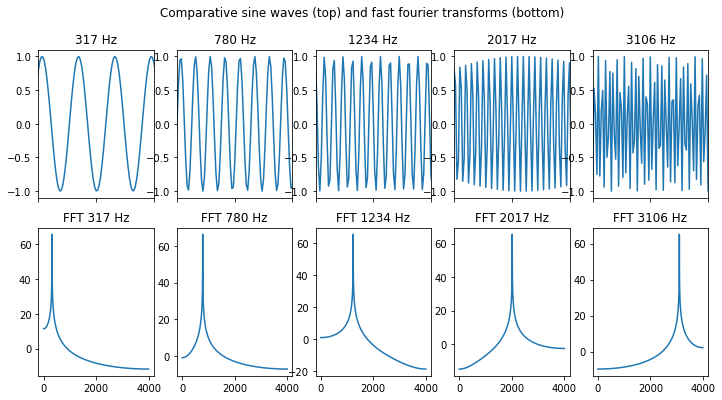

output tensor shape: (1000, 16000, 1)


In [6]:
freq1 = [317, 780, 1234, 2017, 3106]
sec = 2  # seconds
sample_rate = 8000 #Hz
sample_size = 1000 # instances

data = main(f1 = freq1, tim = 2, fs = 8000, sample_size =1000)

We can see from the plots that the number of cycles within the same time period increases as the frequency increases.  Using a Fast Fourier Transform allows us to visualise the peak in power (y-axis) at the relevant frequency (x-axis), indicated by the spike.  In this case, there is only one fundamental frequency in each chart, but a Fast Fourier Transform allows us to decompose and identify they key frequencies that may be mixed into a signal.

## Split the data
We use the sklearn train_test_split function to divide the sampled dataset into training, validation and test datasets.  We will train the model using the training data, occasionally validate the model with the validation data and finally, evaluate the model with the test data.

In [7]:
# split to train test
train_x, test_x, train_y, test_y = train_test_split(data[0].numpy(), 
                                                    np.asarray(data[1]), 
                                                    test_size = 0.3, )

# then split the training data in to train and validation data
val_x = train_x[-150:]
val_y = train_y[-150:]
train_x =train_x[:-150]
train_y = train_y[:-150]

## Initial 1D convolutional neural network model

We initialise a model that convolves additional noise to our sample data, then we apply a 1D convolution, using 32 filters, kernels of size 8, strides = 100, with the ReLU activation. We use MaxPooling to reduce the size of the output and retain the maximum value of each 2-bit pair.  Then we use a flattening layer, before adding two dense layers, the first creating 64 nodes using ReLU activation, the second set up with five nodes to reflect our five possible labels, using a softmax activation to give the node with the highest probability as the predicted class.

We compile the model and fit to the training data, with the validation data feeding the validation process and plot the performance of training and validation data.  We evaluate the model against the test data and report the est accuracy.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise (GaussianNoi  (None, 16000, 1)         0         
 se)                                                             
                                                                 
 gaussian_noise_1 (GaussianN  (None, 16000, 1)         0         
 oise)                                                           
                                                                 
 conv1d (Conv1D)             (None, 160, 32)           288       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 80, 32)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 2560)              0         
                                                        

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


18/18 [==============================] - 2s 56ms/step - loss: 1.2390 - accuracy: 0.5182 - val_loss: 0.6427 - val_accuracy: 1.0000
Epoch 2/10
18/18 [==============================] - 1s 30ms/step - loss: 0.4385 - accuracy: 0.9145 - val_loss: 0.1679 - val_accuracy: 1.0000
Epoch 3/10
18/18 [==============================] - 1s 29ms/step - loss: 0.1250 - accuracy: 0.9945 - val_loss: 0.0570 - val_accuracy: 1.0000
Epoch 4/10
18/18 [==============================] - 1s 38ms/step - loss: 0.0516 - accuracy: 1.0000 - val_loss: 0.0279 - val_accuracy: 1.0000
Epoch 5/10
18/18 [==============================] - 1s 29ms/step - loss: 0.0331 - accuracy: 1.0000 - val_loss: 0.0174 - val_accuracy: 1.0000
Epoch 6/10
18/18 [==============================] - 1s 30ms/step - loss: 0.0186 - accuracy: 1.0000 - val_loss: 0.0124 - val_accuracy: 1.0000
Epoch 7/10
18/18 [==============================] - 1s 30ms/step - loss: 0.0135 - accuracy: 1.0000 - val_loss: 0.0095 - val_accuracy: 1.0000
Epoch 8/10
18/18 [======

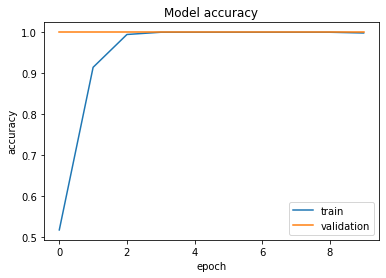

10/10 [==============================] - 0s 6ms/step - loss: 0.0048 - accuracy: 1.0000
testloss, test accuracy: [0.004831331316381693, 1.0]


In [8]:
# set epoch value
epoch = 10

# we generate a simple model using 1D convolution, add Gaussian 
model1 = models.Sequential()
model1.add(layers.Input(shape = train_x.shape[1:] ))
model1.add(layers.GaussianNoise(1, seed = 425))
model1.add(layers.GaussianNoise(1, seed = 300212228)) # seems too good
model1.add(layers.Conv1D(32, 8, strides = 100, activation = 'relu'))
model1.add(layers.MaxPool1D()) #pool_size = 2 # very good
model1.add(layers.Flatten())
model1.add(layers.Dense(64, activation = 'relu'))
model1.add(layers.Dense(5, activation = 'softmax'))
model1.summary()

# compile: optimizer, loss, metrics
model1.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

# fit: to the training set, include validation data
history1 = model1.fit(train_x, 
                    train_y, 
                    epochs = epoch,
                    validation_data=(val_x, val_y))

# plot the model accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], 
           loc = 'lower right')
plt.show()

# evaluate: on the test dataset
results1 = model1.evaluate(test_x, test_y)
print("testloss, test accuracy:", results1)

### The 1D convolution performs very well on training and validation data

The 1D convolutional neural network performs very well in predicting the class of noisy input signals, with 100% accuracy on the training set achieved after just one epoch.  This should not be surprising as we are using a 1D convolution with an 8 bit kernel.  Because our signals are sampled at 8kHz, this means there are 16,000 individual timesteps in each signal vector.  Using an 8 bit kernel with stride = 100, means that the 1D convolution can 'perceive' any frequency up to eight times higher than the sample rate (i.e. up to 64 kHz).  The pooling layer, with pool size = 2, reduces resolution by half, but this still allows for successfully distinguishing frequencies up to 32kHz.  

Since all of our input frequencies are much lower than 32kHz, the network can easily discern and therefore train to detect those relatively low frequencies.  This is because an input frequency at say 1kHz will peak at +1 and -1 exactly 1000 times each second.  With the 1d convlution kernel sensitive to 8 bits, sampling at 8000 times per second, the kernel will detect each of those +1 peaks and -1 troughs eight times in a single pass, giving very high reinforcement of the (time) position of each of those peaks and troughs, and consequently, the parameters of the underlying frequency.

## what happens when we adjust the 1D convolution

In the previous model, we had a kernel 8-bits wide, with stride 100.  If we increase the pool size, while retaining the stride length, we should see a decrease in performance as the model has fewer timesteps from which to learn (i.e. $8 * \frac{16000}{100} = 1280$ reference points in the 1D convolution, reduced by a factor of 8, gives 160 reference points through each of the 32 filters.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise_2 (GaussianN  (None, 16000, 1)         0         
 oise)                                                           
                                                                 
 gaussian_noise_3 (GaussianN  (None, 16000, 1)         0         
 oise)                                                           
                                                                 
 conv1d_1 (Conv1D)           (None, 160, 32)           288       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 20, 32)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 640)               0         
                                                      

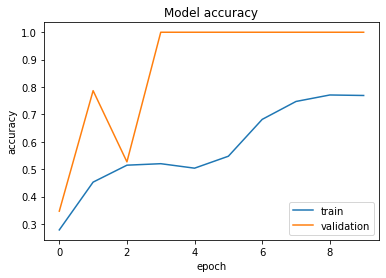

10/10 [==============================] - 0s 3ms/step - loss: 0.5321 - accuracy: 1.0000
testloss, test accuracy: [0.5321377515792847, 1.0]


In [9]:
# we generate a simple model using 1D convolution, add Gaussian 
# reduce kernel size and increase pool size
model = models.Sequential()
model.add(layers.Input(shape = train_x.shape[1:] ))
model.add(layers.GaussianNoise(1, seed = 425))
model.add(layers.GaussianNoise(1, seed = 300212228)) # seems too good
model.add(layers.Conv1D(32, 8, strides = 100, activation = 'relu'))
model.add(layers.MaxPool1D(pool_size = 8)) #pool_size = 2 # very good
model.add(layers.Flatten())
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(5, activation = 'softmax'))
model.summary()

# compile: optimizer, loss, metrics
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

# fit: to the training set, include validation data
history = model.fit(train_x, 
                    train_y, 
                    epochs = epoch,
                    validation_data=(val_x, val_y))

# plot the model accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], 
           loc = 'lower right')
plt.show()


# evaluate: on the test dataset
results = model.evaluate(test_x, test_y)
print("testloss, test accuracy:", results)

When we increase the stride value, and consequently reduce the resolution of the 1D convolution, we see that performance decreases slightly on the training set, but is still very high on the validation and test sets.  

It is not until we set the stride to 180 that we really start seeing degraded performance, but even then, the model still achieves training accuracy above 90%.  Again, this degradation is expected because the model has fewer reference points - at strides = 180, the model resolution is reduced to one kernel every 180 timestamps (i.e. $\frac{16000}{180} = 89$ reference points, through each of the 32 filters).  These reference points are then pooled to just 11 across each of the 32 filters.



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise_4 (GaussianN  (None, 16000, 1)         0         
 oise)                                                           
                                                                 
 gaussian_noise_5 (GaussianN  (None, 16000, 1)         0         
 oise)                                                           
                                                                 
 conv1d_2 (Conv1D)           (None, 89, 32)            288       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 11, 32)           0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 352)               0         
                                                      

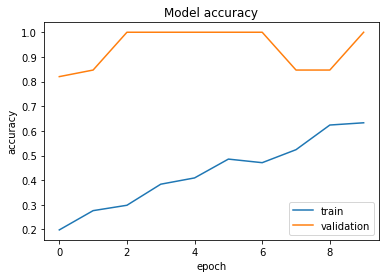

10/10 [==============================] - 0s 3ms/step - loss: 0.7646 - accuracy: 1.0000
testloss, test accuracy: [0.7646247148513794, 1.0]


In [10]:
# we generate a simple model using 1D convolution, add Gaussian 
model3 = models.Sequential()
model3.add(layers.Input(shape = train_x.shape[1:] ))
model3.add(layers.GaussianNoise(1, seed = 425))
model3.add(layers.GaussianNoise(1, seed = 300212228))
model3.add(layers.Conv1D(32, 8, strides = 180, activation = 'relu'))
model3.add(layers.MaxPool1D(pool_size = 8)) 
model3.add(layers.Flatten())
model3.add(layers.Dense(64, activation = 'relu'))
model3.add(layers.Dense(5, activation = 'softmax'))
model3.summary()

# compile: optimizer, loss, metrics
model3.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

# fit: to the training set, include validation data
history3 = model3.fit(train_x, 
                    train_y, 
                    epochs = epoch,
                    validation_data=(val_x, val_y))

# plot the model accuracy
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], 
           loc = 'lower right')
plt.show()


# evaluate: on the test dataset
results3 = model3.evaluate(test_x, test_y)
print("testloss, test accuracy:", results3)

We can see that training accuracy decreases when pool_size = 8, strides = 180.  Validation perfromance varies, but regularly achieves 100% for this model.  Test accuracy achieves 100% for this model.

## what about using a mixture of frequencies?

By combining a mixture of two separate sinusoidal waves, we can generate a new waveform signal that we can feed into the network.  We could assume that the introduction of an additional signal will make the reference (i.e. class label) signal more complex and perhaps more challenging to learn.  

We will add an additional set of frequencies to our original frequencies and combine in pairs to generate five new reference signals.  We add:

$f \in {111, 220, 455, 613, 741}$ Hz frequencies.

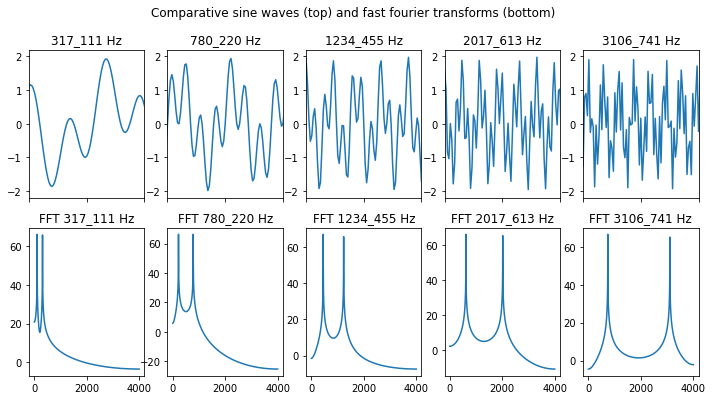

output tensor shape: (1000, 16000, 1)


In [11]:
# create a dataset using a mix of two frequencies
freq2 = [111, 220, 455, 613, 741]

mixed_data = main(f1 = freq1, f2 = freq2, tim = 2, fs = 8000, sample_size =1000)


# split to train test
train_x2, test_x2, train_y2, test_y2 = train_test_split(mixed_data[0].numpy(), 
                                                    np.asarray(mixed_data[1]), 
                                                    test_size = 0.3, )

# then split the training data in to train and validation data
val_x2 = train_x2[-150:]
val_y2 = train_y2[-150:]
train_x2 =train_x2[:-150]
train_y2 = train_y2[:-150]
 

We can see the new signals combining the two input frequeencies generate similar, shaped waveforms.  We also note the fast fourier transform provides two distinct peaks, one for each of the contributing frequencies.

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise_6 (GaussianN  (None, 16000, 1)         0         
 oise)                                                           
                                                                 
 gaussian_noise_7 (GaussianN  (None, 16000, 1)         0         
 oise)                                                           
                                                                 
 conv1d_3 (Conv1D)           (None, 89, 32)            288       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 11, 32)           0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 352)               0         
                                                      

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


18/18 [==============================] - 1s 33ms/step - loss: 1.6421 - accuracy: 0.2291 - val_loss: 1.5118 - val_accuracy: 0.6133
Epoch 2/10
18/18 [==============================] - 0s 25ms/step - loss: 1.5872 - accuracy: 0.2745 - val_loss: 1.4123 - val_accuracy: 1.0000
Epoch 3/10
18/18 [==============================] - 0s 25ms/step - loss: 1.4683 - accuracy: 0.3655 - val_loss: 1.3195 - val_accuracy: 1.0000
Epoch 4/10
18/18 [==============================] - 0s 25ms/step - loss: 1.3778 - accuracy: 0.4782 - val_loss: 1.2026 - val_accuracy: 1.0000
Epoch 5/10
18/18 [==============================] - 0s 25ms/step - loss: 1.2958 - accuracy: 0.5509 - val_loss: 1.0946 - val_accuracy: 1.0000
Epoch 6/10
18/18 [==============================] - 0s 26ms/step - loss: 1.2004 - accuracy: 0.6273 - val_loss: 0.9757 - val_accuracy: 1.0000
Epoch 7/10
18/18 [==============================] - 0s 25ms/step - loss: 1.1378 - accuracy: 0.6145 - val_loss: 0.8507 - val_accuracy: 1.0000
Epoch 8/10
18/18 [======

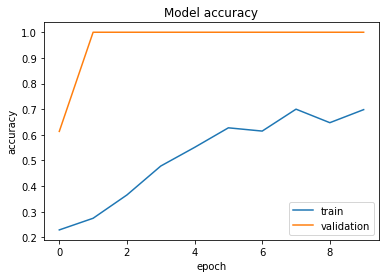

10/10 [==============================] - 0s 3ms/step - loss: 0.5411 - accuracy: 1.0000
testloss, test accuracy: [0.5410621166229248, 1.0]


In [12]:
# we generate a simple model using 1D convolution, add Gaussian 
model2 = models.Sequential()
model2.add(layers.Input(shape = train_x2.shape[1:] ))
model2.add(layers.GaussianNoise(1, seed = 425))
model2.add(layers.GaussianNoise(1, seed = 300212228)) # seems too good
model2.add(layers.Conv1D(32, 8, activation = 'relu', strides = 180))
model2.add(layers.MaxPool1D(pool_size = 8)) 
model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation = 'relu'))
model2.add(layers.Dense(5, activation = 'softmax'))
model2.summary()

# compile: optimizer, loss, metrics
model2.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])


# fit: to the training set, include validation data
history2 = model2.fit(train_x2, 
                    train_y2, 
                    epochs = epoch,
                    validation_data=(val_x2, val_y2))

# plot the model accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], 
           loc = 'lower right')
plt.show()

# evaluate: on the test dataset
results2 = model2.evaluate(test_x2, test_y2)
print("testloss, test accuracy:", results2)




The results of the mixed-frequency models are comparable to our single frequency model, with stride 180 for both training, validation and test accuracies.  The reason for the similarity is that even though the single frequency model was learning a single frequency, the mixed model, combines to essentially form a new signal that is equally unique and cyclic.  The 1D convolution model can easily detect signals with constant waveform through the entire signal (e.g. an audio tone) because each the regularity of the frequency signal acts to reinforce the audio signature of the class label.  In other words, using a single tone, constant tone, regardless of the complexity of its composition, creates regular, consistent peaks (and troughs) that are captured by the neural network.

Although training accuracy is reduced, the model trains very quickly as a result of the layered signal reduction through the network (e.g. increased strides, increased pool_size etc.).  

It would be interesting to train this neural network against audio signals that are more irregular and complex (e.g. spoken phrases, bird-song, or ambient noises in a cafe etc.).  A

In [14]:
!git clone https://github.com/ctkakau/AIML425_A3.git

Cloning into 'AIML425_A3'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.


In [15]:
# !git push https://github.com/ctkakau/AIML425_A3.git

fatal: not a git repository (or any of the parent directories): .git
